In [1]:
import numpy as np
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

## SIMULATE DATA
We generate a theoretical population of size <i>N</i>, and draw a sample of <i>n</i> from it.<br>
Hint: choosing the first 5000 is just as random in this case as any other method.

In [2]:
np.random.seed(101)
N = 50000 # the theoretical population size
n = 5000 # sample size 5000 user gets the new landing page, 5000 gets the old one

p_control = 0.01 # let's say 1% of the users getting the old page subscribe 
p_treatment = 0.005    # let's say 0.5% of the users getting the new page subscribe 

In [3]:
# generate data with the above probabilities
# 1 means a user subscribed, 0 means leaving without subscription
control_subscribes_pop = [np.random.choice(np.arange(0, 2), p = [(1 - p_control), p_control]) for f in range(N)]
treatment_subscribes_pop = [np.random.choice(np.arange(0, 2), p = [(1 - p_treatment), p_treatment]) for f in range(N)]

In [4]:
control_subscribes = control_subscribes_pop[:5000]
treatment_subscribes = treatment_subscribes_pop[:5000]

## MEAN

In [5]:
print(f"{np.mean(control_subscribes_pop):0.3%}") # calculate mean of population of NOT treated visitors

1.044%


In [6]:
print(f"{np.mean(treatment_subscribes_pop):0.3%}") # calculate mean of population of treated visitors

0.506%


In [7]:
print(f"{np.mean(control_subscribes):0.3%}") # calculate mean of sample of NOT treated visitors

1.040%


In [8]:
print(f"{np.mean(treatment_subscribes):0.3%}") # calculate mean of sample of treated visitors

0.660%


## BOOTSTRAPPED MEAN

Perform bootstrapping.<br>
This means resampling the data with replacement 5000 (num_iterations) times (therefore some values will be duplicates).<br>
By this, we obtain an empirical distribution of sample means.<br>
From this distribution we can calculate percentiles, which will serve as confidence intervals.<br>
Here I chose 99% (1 - alpha) as confidence interval.<br>

In [9]:
alpha = 0.01 # confidence interval (1-alpha)
n_samples = 5000 # number of resamples

# calculate mean using bootstrap on both samples
bootstrapped_mean_control = bs.bootstrap(np.array(control_subscribes),
                                             stat_func=bs_stats.mean,
                                             alpha=alpha,
                                             num_iterations=n_samples)
bootstrapped_mean_treatment = bs.bootstrap(np.array(treatment_subscribes),
                                         stat_func=bs_stats.mean,
                                         alpha=alpha,
                                         num_iterations=n_samples)

In [10]:
print(f"After resampling {n_samples} times...\n")
print(f"The bootstrapped mean estimation of NOT treated visitors is {bootstrapped_mean_control.value:0.3%}.")
print(f"The {(1-alpha):.0%} confidence interval is between {bootstrapped_mean_control.lower_bound:0.3%} \
      and {bootstrapped_mean_control.upper_bound:0.3%}")
print("\n")
print(f"The bootstrapped mean estimation of treated visitors is {bootstrapped_mean_treatment.value:0.3%}.")
print(f"The {(1-alpha):.0%} confidence interval is between {bootstrapped_mean_treatment.lower_bound:0.3%} \
      and {bootstrapped_mean_treatment.upper_bound:0.3%}")

After resampling 5000 times...

The bootstrapped mean estimation of NOT treated visitors is 1.040%.
The 99% confidence interval is between 0.620%       and 1.380%


The bootstrapped mean estimation of treated visitors is 0.660%.
The 99% confidence interval is between 0.340%       and 0.940%


## T-TEST
Perform T-test on equality of means:<br>
H0: mean_not_treated = mean_treated<br>
H1: mean_not_treated != mean_treated

In [11]:
# bootstrapping: return distribution of sample means
bootstrapped_meandist_control = bs.bootstrap(np.array(control_subscribes),
                                                 stat_func=bs_stats.mean,
                                                 alpha=alpha,
                                                 num_iterations=n_samples,
                                                 return_distribution=True)
bootstrapped_meandist_treatment = bs.bootstrap(np.array(treatment_subscribes),
                                             stat_func=bs_stats.mean,
                                             alpha=alpha,
                                             num_iterations=n_samples,
                                             return_distribution=True)

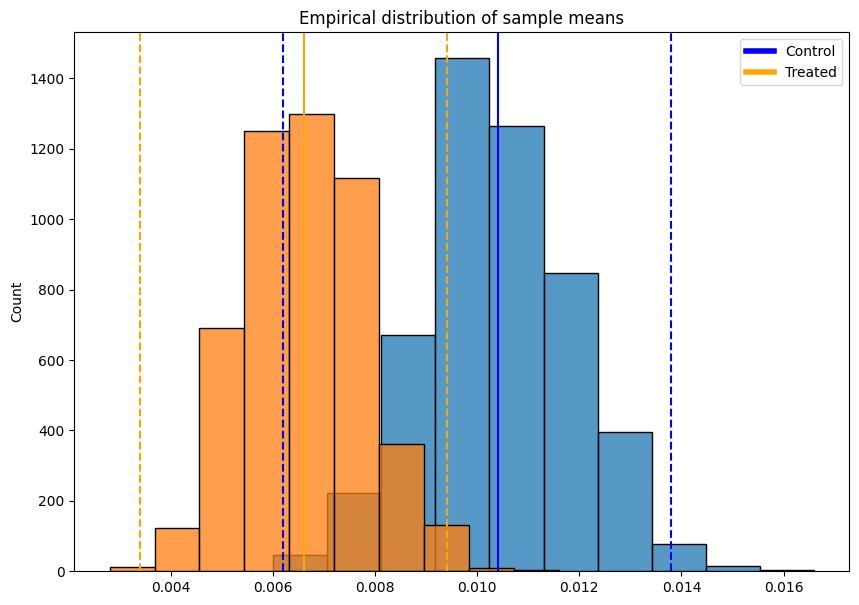

In [22]:
fig, ax = plt.subplots(figsize = (10,7))
sns.histplot(bootstrapped_meandist_control, bins = 10, ax = ax, kde = False)
sns.histplot(bootstrapped_meandist_treatment, bins = 10, ax = ax, kde = False)
plt.axvline(bootstrapped_mean_control.value, color = 'blue')
plt.axvline(bootstrapped_mean_control.lower_bound, color = 'blue', linestyle = '--')
plt.axvline(bootstrapped_mean_control.upper_bound, color = 'blue', linestyle = '--')
plt.axvline(bootstrapped_mean_treatment.value, color = 'orange')
plt.axvline(bootstrapped_mean_treatment.lower_bound, color = 'orange', linestyle = '--')
plt.axvline(bootstrapped_mean_treatment.upper_bound, color = 'orange', linestyle = '--')
plt.title('Empirical distribution of sample means')
custom_legend = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='orange', lw=4)]
ax.legend(custom_legend, ['Control', 'Treated'])

In [23]:
scipy_ttest = stats.ttest_ind(bootstrapped_meandist_control, bootstrapped_meandist_treatment)
print(f"Probability of H0 (equal means) being true: {scipy_ttest.pvalue:0.0%}.")

Probability of H0 (equal means) being true: 0%.


In [24]:
# or code out?

In [25]:
# calculate variances of sample mean distributions
var_treatment = np.array(bootstrapped_meandist_control).var(ddof = 1)
var_control = np.array(bootstrapped_meandist_treatment).var(ddof = 1)
print(f"Variance of treated visitors:\t\t {var_treatment}")
print(f"Variance of NOT treated visitors:\t {var_control}")

Variance of treated visitors:		 2.12183300660132e-06
Variance of NOT treated visitors:	 1.3181146053210643e-06


In [26]:
# calculate s for t-test
s = np.sqrt((var_treatment + var_control) / 2)

In [27]:
# calculate t-statistic
t = (np.mean(bootstrapped_meandist_control) - np.mean(bootstrapped_meandist_treatment)) / (s * np.sqrt(2 / n))
print(f"Value of t-statistic: {t}")

Value of t-statistic: 145.17364444945258


In [28]:
# calculate degrees of freedom
df = 2 * n - 2
print(f"Degrees of freedom: {df}")

Degrees of freedom: 9998


In [29]:
# calculate probability of H0
p = 1 - stats.t.cdf(t, df=df)
print(f"Probability of H0 (equal means) being true: {p:0.0%}.")

Probability of H0 (equal means) being true: 0%.


### By this we destroyed the idea of the large, red, flashing SUBSCRIBE button.

## CHECKS

In [30]:
p == scipy_ttest.pvalue

True

In [31]:
t == scipy_ttest.statistic

True